In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import foolbox

# from keras.datasets import mnist
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [29]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "./lenet_mnist_model.pth"
use_cuda=True

mean = (0.1307,)
std = (0.3081,)

train_mnist = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
#                            transforms.Resize((224, 224)),
#                            transforms.ToTensor(),
#                            transforms.Normalize(mean, std)
                       ]))

test_mnist = datasets.MNIST('../data', train=False, download=True,
                       transform=transforms.Compose([
#                            transforms.Resize((224, 224)),
                           transforms.ToTensor(),
#                            transforms.Normalize(mean, std)
                       ]))

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(test_mnist,batch_size=1, shuffle=True)

# (x_train, y_train), (x_test, y_test) = mnist.load_data()

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [30]:
# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cuda'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))

(torch.Size([1, 28, 28]), 1)
predicted class 1
(1, 28, 28)
adversarial class 2


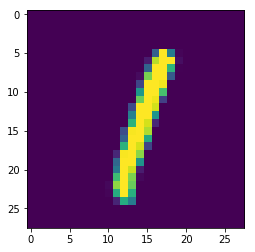

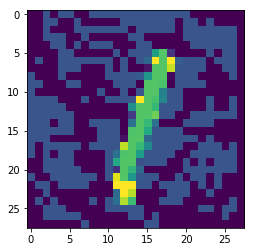

In [61]:
# attack = foolbox.attacks.GradientAttack(fmodel)
attack = foolbox.attacks.FGSM(fmodel)

image, label = test_mnist[5]; print((image.shape, label))
print('predicted class', np.argmax(fmodel.forward(np.expand_dims(image, 0))))
plt.figure()
plt.imshow(image[0,:,:])
# adversarial = attack(image.numpy(), label, epsilons=[0.13]); 
adversarial = attack(image.numpy(), label); 
print(adversarial.shape)
print('adversarial class', np.argmax(fmodel.forward(np.expand_dims(adversarial, 0))))
plt.figure()
plt.imshow(adversarial[0,:,:])

In [86]:
# Accuracy counter
correct = 0
classifier_failed = 0
adversary_succeeded = 0
adversary_failed = 0
adv_examples = []
# epsilon = 0.5
# attack = foolbox.attacks.GradientAttack(fmodel)
attack = foolbox.attacks.FGSM(fmodel)
attack_name = "fgsm"
attack_image_folder = "./" + attack_name + "/"
!mkdir -p $attack_image_folder


# Loop over all examples in test set
for i in tqdm.tqdm_notebook(range(len(test_mnist))):

    # Send the data and label to the device
    image, target = test_mnist[i]

    # Forward pass the data through the model
    output = fmodel.forward(np.expand_dims(image, 0))
    init_pred = np.argmax(output) # get the index of the max log-probability

    # If the initial prediction is wrong, dont bother attacking, just move on
    if init_pred != target:
        classifier_failed += 1
        continue

    # Call FGSM Attack
    adversarial = attack(image.numpy(), label)

    if adversarial is None:
        adversary_failed += 1
        continue
    
    # Re-classify the perturbed image
    adv_output = fmodel.forward(np.expand_dims(adversarial, 0))
    perturbed_pred = np.argmax(adv_output)

    # Check for success
    if perturbed_pred == target:
        correct += 1
    else:
        adversary_succeeded += 1
        output_image = (adversarial[0,:,:] * 255).astype(np.uint8)
        imageio.imsave(attack_image_folder + attack_name + "_" + str(i) + ".png", output_image)
        with open(attack_image_folder + attack_name + "_" + str(i) + ".txt", "w") as file:
            file.write(str(perturbed_pred))

# Calculate final accuracy for this epsilon
final_acc = correct/float(len(test_loader))
print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:133: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


Epsilon: 0.5	Test Accuracy = 8707 / 10000 = 0.8707


(1, 28, 28)
adversarial class 6


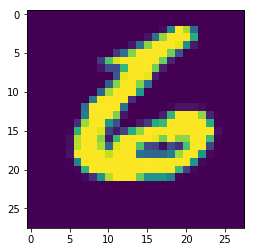

In [69]:
print(adversarial.shape)
print('adversarial class', np.argmax(fmodel.forward(np.expand_dims(adversarial, 0))))
plt.figure()
plt.imshow(adversarial[0,:,:])

In [75]:
imageio.imsave("testing_saving.png", adversarial[0,:,:])

In [66]:
print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))
print("Adversary succeeded {} / Adversary failed {} ".format(adversary_succeeded, adversary_failed))
print("Classifier succeeded {} / Classifier failed {} ".format(correct, classifier_failed))

Test Accuracy = 8707 / 10000 = 0.8707
Adversary succeeded 1131 / Adversary failed 0 
Classifier succeeded 8707 / Classifier failed 162 


In [67]:
correct + classifier_failed + adversary_succeeded + adversary_failed

10000